In [2]:
import sys
sys.path.append('./model_construction/')

In [3]:

import logging
import time
from argparse import ArgumentParser

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import datasets
import utils
import model
from nni.nas.pytorch.utils import AverageMeter
from nni.retiarii import fixed_arch
import random
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set('talk')
plt.rcParams['figure.figsize'] = (12, 9)

/usr/local/lib/python3.8/dist-packages/pandas/compat/_optional.py:149: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
device = 'cuda'

In [5]:
def accuracy(model):            
    total = 0
    correct = 0    
    for x,y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        
        out = model(x)
        
        correct += torch.eq(out.argmax(1), y).sum()
        total += len(x)
    return (correct/total).item()

def fgsm_accuracy(model, eps):
    total = 0
    correct = 0 
    crit = torch.nn.CrossEntropyLoss()
    
    for x,y in valid_loader:
        x = x.to(device)
        x.requires_grad = True
        y = y.to(device)
        model.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        grad_sign = x.grad.data.sign()
        x = x + grad_sign * eps 
        out = model(x)
        correct += torch.eq(out.argmax(1), y).sum()
        total += len(x)
    return (correct/total).item()

In [6]:
_, dataset_valid = datasets.get_dataset("fmnist3", cutout_length=0)
valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                               batch_size=64,
                                               shuffle=False,
                                               num_workers=4,
                                               pin_memory=True)


    

In [7]:
import tqdm
def model_eval(path_to_json, path_to_pt, class_num):
    with fixed_arch(path_to_json):
        cnn_model = model.CNN(28, 1, 16, class_num, 3, auxiliary=False, node_cls = model.ZeroNode)
        cnn_model.load_state_dict(torch.load(path_to_pt), strict=False)
        cnn_model = cnn_model.to(device).eval()  
        res = []
        for eps in tqdm.tqdm_notebook([0, 1e-3, 1e-2, 0.05, 0.1]):
            if eps == 0:
                res.append(accuracy(cnn_model))
            else:
                res.append(fgsm_accuracy(cnn_model, eps))
            
        del cnn_model
        return res

In [8]:
# fmnist2 -> fmnist3
fmnist_23 = model_eval('./model_construction/darts_fmnist2_fmnist3/checkpoint.json', './model_construction/darts_fmnist2_fmnist3/optimized_darts.pt', 8)
fmnist_23

[2022-07-07 22:11:32] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'sepconv3x3', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'sepconv5x5', 'normal_n4_p1': 'sepconv3x3', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'dilconv5x5', 'normal_n5_p4': 'dilconv5x5', 'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'dilconv5x5', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switc

/tmp/ipykernel_91318/4225649311.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eps in tqdm.tqdm_notebook([0, 1e-3, 1e-2, 0.05, 0.1]):


  0%|          | 0/5 [00:00<?, ?it/s]

[0.7585000395774841,
 0.7425000071525574,
 0.5855000019073486,
 0.23850001394748688,
 0.14400000870227814]

In [9]:
# fmnist3
fmnist_3 = model_eval('./model_construction/darts_fmnst3/checkpoint.json', './model_construction/darts_fmnst3/optimized_darts.pt', 8)
fmnist_3 

[2022-07-07 22:12:30] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'dilconv3x3', 'normal_n3_p1': 'sepconv3x3', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'sepconv3x3', 'normal_n4_p1': 'sepconv5x5', 'normal_n4_p2': 'dilconv5x5', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'sepconv3x3', 'normal_n5_p1': 'sepconv3x3', 'normal_n5_p2': 'dilconv5x5', 'normal_n5_p3': 'sepconv5x5', 'normal_n5_p4': 'dilconv3x3', 'reduce_n2_p0': 'sepconv3x3', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'dilconv3x3', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'skipconnect', 'reduce_n5_p0': 'dilconv3x3', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'skipconnect', 'reduce_n5_p3': 'skipconnect', 'reduce_n5_p4': 'skipconnect', 'normal_n2_switch': [0, 1], 'normal_n3_switch': [2, 0], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [3, 0], '

/tmp/ipykernel_91318/4225649311.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eps in tqdm.tqdm_notebook([0, 1e-3, 1e-2, 0.05, 0.1]):


  0%|          | 0/5 [00:00<?, ?it/s]

[0.905500054359436,
 0.8970000147819519,
 0.800000011920929,
 0.3815000057220459,
 0.2600000202655792]

In [10]:
rand = {}
for run in range(3):
    for perc in [25, 50, 75]:
        key = run, perc
        rand[key] =  model_eval(f'./model_construction/random_pruned/{run}_{perc}.json', f'./model_construction/random_pruned/{run}_{perc}.pt', 8)
        print (key, rand[key])

[2022-07-07 22:13:09] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'sepconv3x3', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'zero', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'dilconv5x5', 'normal_n5_p4': 'dilconv5x5', 'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'zero', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], 'reduce_n3_switch': [2, 

/tmp/ipykernel_91318/4225649311.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eps in tqdm.tqdm_notebook([0, 1e-3, 1e-2, 0.05, 0.1]):


  0%|          | 0/5 [00:00<?, ?it/s]

(0, 25) [0.675000011920929, 0.655500054359436, 0.5220000147819519, 0.31200000643730164, 0.2670000195503235]
[2022-07-07 22:13:42] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'zero', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'dilconv5x5', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch

  0%|          | 0/5 [00:00<?, ?it/s]

(0, 50) [0.9345000386238098, 0.9285000562667847, 0.831000030040741, 0.3880000114440918, 0.2175000160932541]
[2022-07-07 22:14:05] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'zero', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'zero', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'zero', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'zero', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'zero', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], '

  0%|          | 0/5 [00:00<?, ?it/s]

(0, 75) [0.8975000381469727, 0.8865000605583191, 0.768500030040741, 0.3360000252723694, 0.27300000190734863]
[2022-07-07 22:14:27] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'sepconv3x3', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'sepconv5x5', 'normal_n4_p1': 'sepconv3x3', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'zero', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'dilconv5x5', 'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'zero', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'dilconv5x5', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 

  0%|          | 0/5 [00:00<?, ?it/s]

(1, 25) [0.7145000100135803, 0.6990000605583191, 0.5509999990463257, 0.2900000214576721, 0.23100000619888306]
[2022-07-07 22:15:02] Fixed architecture: {'normal_n2_p0': 'zero', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'dilconv5x5', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'zero', 'reduce_n3_p2': 'dilconv5x5', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'zero', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switc

  0%|          | 0/5 [00:00<?, ?it/s]

(1, 50) [0.7630000114440918, 0.7445000410079956, 0.6310000419616699, 0.4830000102519989, 0.4400000274181366]
[2022-07-07 22:15:29] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'sepconv5x5', 'normal_n4_p1': 'sepconv3x3', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'zero', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'zero', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'zero', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'zero', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1

  0%|          | 0/5 [00:00<?, ?it/s]

(1, 75) [0.9305000305175781, 0.9200000166893005, 0.7880000472068787, 0.4025000333786011, 0.3100000023841858]
[2022-07-07 22:15:50] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'sepconv3x3', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'sepconv5x5', 'normal_n4_p1': 'sepconv3x3', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'dilconv5x5', 'normal_n5_p4': 'dilconv5x5', 'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'dilconv5x5', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'n

  0%|          | 0/5 [00:00<?, ?it/s]

(2, 25) [0.7415000200271606, 0.7240000367164612, 0.5605000257492065, 0.24900001287460327, 0.18650001287460327]
[2022-07-07 22:16:23] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'sepconv3x3', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'zero', 'normal_n4_p0': 'sepconv5x5', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'dilconv5x5', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'zero', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'zero', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_swit

  0%|          | 0/5 [00:00<?, ?it/s]

(2, 50) [0.9190000295639038, 0.9115000367164612, 0.8300000429153442, 0.47450003027915955, 0.3700000047683716]
[2022-07-07 22:16:53] Fixed architecture: {'normal_n2_p0': 'zero', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'zero', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'sepconv3x3', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'zero', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'zero', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'zero', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], '

  0%|          | 0/5 [00:00<?, ?it/s]

(2, 75) [0.8810000419616699, 0.8655000329017639, 0.6395000219345093, 0.19200000166893005, 0.30100002884864807]


In [11]:
gamma_sigmoid_full = {}
current = gamma_sigmoid_full
for perc in [25, 50, 75]:
        key = perc
        current[key] =  model_eval(f'./model_construction/naive_dartslike_retrain/prune_{perc}.json', f'./model_construction/naive_dartslike_retrain/prune_{perc}.pt', 2)
        print (key, current[key])

[2022-07-07 22:17:12] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'sepconv3x3', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'sepconv5x5', 'normal_n4_p1': 'sepconv3x3', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'dilconv5x5', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'zero', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], 'reduce_n3_switch': [2, 1], 'reduce_n4_swi

/tmp/ipykernel_91318/4225649311.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eps in tqdm.tqdm_notebook([0, 1e-3, 1e-2, 0.05, 0.1]):


  0%|          | 0/5 [00:00<?, ?it/s]

25 [0.9180000424385071, 0.9095000624656677, 0.7445000410079956, 0.3660000264644623, 0.32100000977516174]
[2022-07-07 22:17:37] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'zero', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce

  0%|          | 0/5 [00:00<?, ?it/s]

50 [0.9440000653266907, 0.9345000386238098, 0.8160000443458557, 0.3135000169277191, 0.1835000067949295]
[2022-07-07 22:17:56] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'zero', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'zero', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'zero', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], 'reduce_n3_swi

  0%|          | 0/5 [00:00<?, ?it/s]

75 [0.9300000667572021, 0.9225000143051147, 0.8075000643730164, 0.40550002455711365, 0.31950002908706665]


In [17]:
gamma_gs_full = {}
current = gamma_gs_full
for perc in [25, 50, 75]:
        key = perc
        current[key] =  model_eval(f'./model_construction/naive_dartslike_retrain_gs/prune_{perc}.json', f'./model_construction/naive_dartslike_retrain_gs/prune_{perc}.pt', 2)
        print (key, current[key])

[2022-07-07 23:03:13] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'dilconv5x5', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], 'reduce_n3_switch': [2, 1], 'reduce_n4_switch': 

/tmp/ipykernel_91318/4225649311.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eps in tqdm.tqdm_notebook([0, 1e-3, 1e-2, 0.05, 0.1]):


  0%|          | 0/5 [00:00<?, ?it/s]

25 [0.9395000338554382, 0.9325000643730164, 0.8485000133514404, 0.4425000250339508, 0.29350000619888306]
[2022-07-07 23:03:32] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'maxpool', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'dilconv5x5', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'zero', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'zero', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [

  0%|          | 0/5 [00:00<?, ?it/s]

50 [0.9435000419616699, 0.937000036239624, 0.8470000624656677, 0.44850000739097595, 0.2565000057220459]
[2022-07-07 23:03:50] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'zero', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'zero', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], 'redu

  0%|          | 0/5 [00:00<?, ?it/s]

75 [0.9340000152587891, 0.9250000715255737, 0.8225000500679016, 0.3680000305175781, 0.2735000252723694]


In [13]:
gamma_sigmoid_head = {}
current = gamma_sigmoid_head
for perc in [25, 50, 75]:
        key = perc
        current[key] =  model_eval(f'./model_construction/naive_dartslike_retrain_head/prune_{perc}.json', f'./model_construction/naive_dartslike_retrain_head/prune_{perc}.pt', 2)
        print (key, current[key])

[2022-07-07 22:19:45] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'sepconv3x3', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'sepconv5x5', 'normal_n4_p1': 'sepconv3x3', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'dilconv5x5', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'zero', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], 'reduce_n3_switch': [2, 1], 'redu

/tmp/ipykernel_91318/4225649311.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eps in tqdm.tqdm_notebook([0, 1e-3, 1e-2, 0.05, 0.1]):


  0%|          | 0/5 [00:00<?, ?it/s]

25 [0.924500048160553, 0.9190000295639038, 0.8030000329017639, 0.3140000104904175, 0.24150000512599945]
[2022-07-07 22:20:11] Fixed architecture: {'normal_n2_p0': 'zero', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'zero', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch'

  0%|          | 0/5 [00:00<?, ?it/s]

50 [0.9105000495910645, 0.9005000591278076, 0.7730000615119934, 0.38200002908706665, 0.36500000953674316]
[2022-07-07 22:20:34] Fixed architecture: {'normal_n2_p0': 'zero', 'normal_n2_p1': 'sepconv3x3', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'zero', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'zero', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'zero', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'zero', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'sepconv5x5', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], 'reduce_n3_s

  0%|          | 0/5 [00:00<?, ?it/s]

75 [0.9285000562667847, 0.9180000424385071, 0.7870000600814819, 0.20350000262260437, 0.20800000429153442]


In [14]:
molchanov = {}
current = molchanov
for perc in [25, 50, 75]:
        key = perc
        current[key] =  model_eval(f'./model_construction/molchanov/prune_{perc}.json', f'./model_construction/molchanov/prune_{perc}.pt', 2)
        print (key, current[key])

[2022-07-07 22:20:57] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'sepconv3x3', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'sepconv5x5', 'normal_n4_p0': 'sepconv5x5', 'normal_n4_p1': 'sepconv3x3', 'normal_n4_p2': 'maxpool', 'normal_n4_p3': 'sepconv5x5', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'sepconv3x3', 'normal_n5_p3': 'dilconv5x5', 'normal_n5_p4': 'dilconv5x5', 'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'zero', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'zero', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], 'reduce_n3_switch': [2, 1], 'reduce_

/tmp/ipykernel_91318/4225649311.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eps in tqdm.tqdm_notebook([0, 1e-3, 1e-2, 0.05, 0.1]):


  0%|          | 0/5 [00:00<?, ?it/s]

25 [0.8985000252723694, 0.8825000524520874, 0.7240000367164612, 0.3830000162124634, 0.34050002694129944]
[2022-07-07 22:21:22] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'sepconv3x3', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'zero', 'normal_n4_p0': 'sepconv5x5', 'normal_n4_p1': 'sepconv3x3', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'dilconv3x3', 'normal_n5_p1': 'dilconv5x5', 'normal_n5_p2': 'zero', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'dilconv5x5', 'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'zero', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'zero', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_swi

  0%|          | 0/5 [00:00<?, ?it/s]

50 [0.7620000243186951, 0.7305000424385071, 0.550000011920929, 0.367000013589859, 0.2915000021457672]
[2022-07-07 22:21:42] Fixed architecture: {'normal_n2_p0': 'sepconv3x3', 'normal_n2_p1': 'zero', 'normal_n3_p0': 'zero', 'normal_n3_p1': 'zero', 'normal_n3_p2': 'zero', 'normal_n4_p0': 'zero', 'normal_n4_p1': 'zero', 'normal_n4_p2': 'zero', 'normal_n4_p3': 'zero', 'normal_n5_p0': 'zero', 'normal_n5_p1': 'zero', 'normal_n5_p2': 'zero', 'normal_n5_p3': 'zero', 'normal_n5_p4': 'zero', 'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'zero', 'reduce_n3_p0': 'zero', 'reduce_n3_p1': 'zero', 'reduce_n3_p2': 'zero', 'reduce_n4_p0': 'zero', 'reduce_n4_p1': 'zero', 'reduce_n4_p2': 'zero', 'reduce_n4_p3': 'zero', 'reduce_n5_p0': 'zero', 'reduce_n5_p1': 'zero', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'zero', 'reduce_n5_p4': 'zero', 'normal_n2_switch': [1, 0], 'normal_n3_switch': [2, 1], 'normal_n4_switch': [3, 2], 'normal_n5_switch': [2, 3], 'reduce_n2_switch': [1, 0], 'reduce_n3_switch': [2, 1

  0%|          | 0/5 [00:00<?, ?it/s]

75 [0.7600000500679016, 0.7415000200271606, 0.5445000529289246, 0.3255000114440918, 0.2670000195503235]


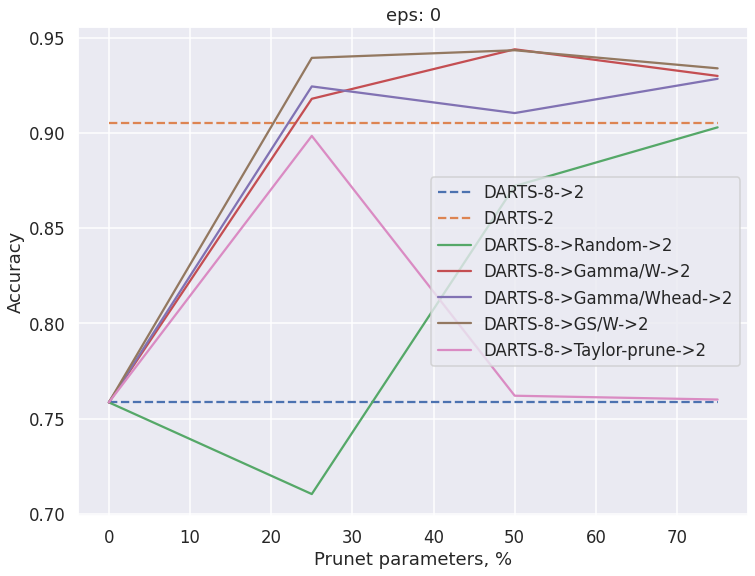

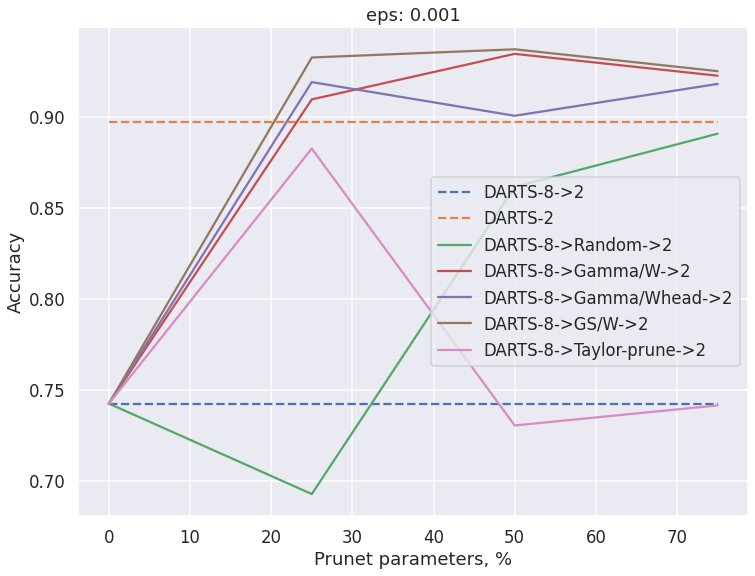

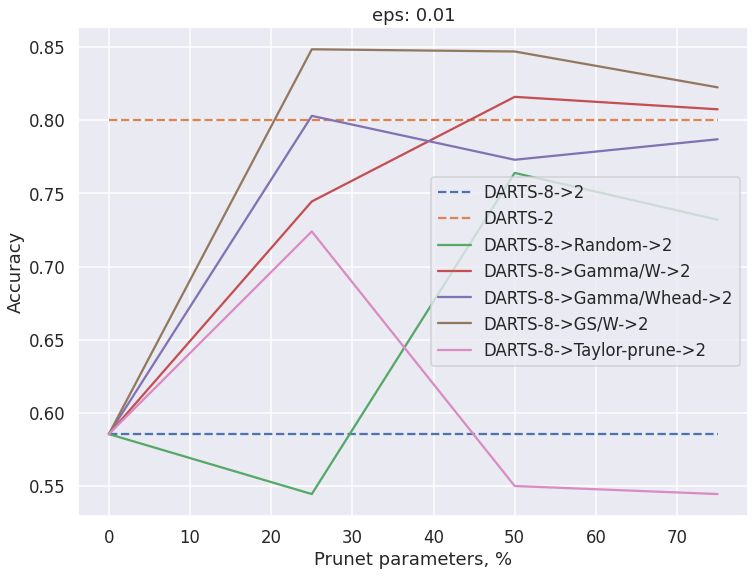

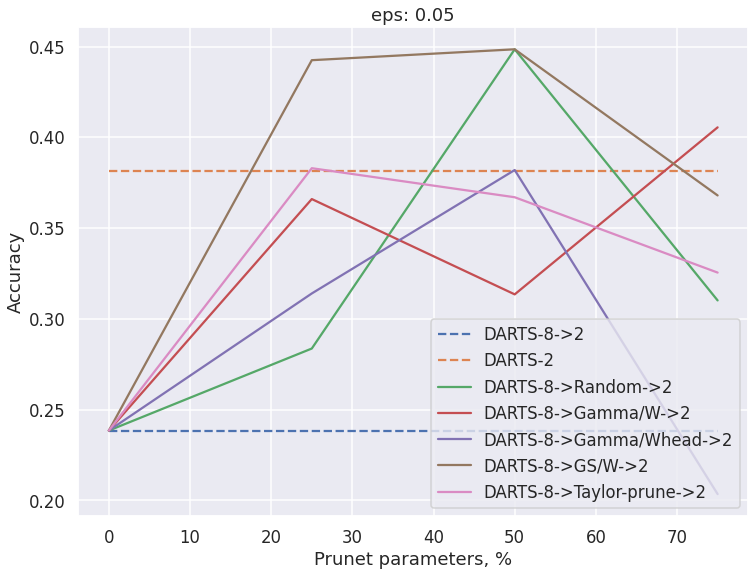

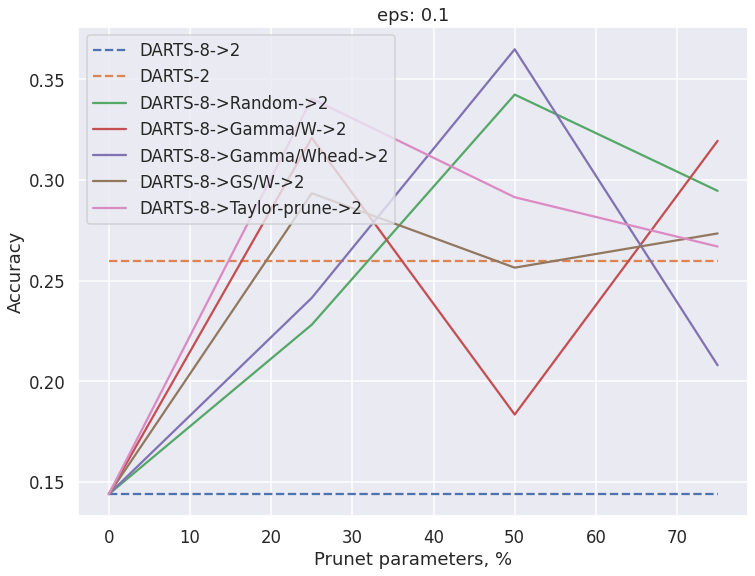

In [20]:
for eps_id, eps in enumerate([0, 1e-3, 1e-2, 0.05, 1e-1]):
    plt.title(f'eps: {eps}')
    plt.plot([0, 25, 50, 75], [fmnist_23[eps_id]]*4, label='DARTS-8->2', ls='--')
    plt.plot([0, 25, 50, 75], [fmnist_3[eps_id]]*4, label='DARTS-2', ls='--')
    
    x = [0, 25, 50, 75]
    y = [fmnist_23[eps_id]]
    for perc in [25, 50, 75]:
        y_ = []
        for run in range(3):
            y_.append(rand[(run, perc)][eps_id])
        y.append(np.mean(y_))
        
    plt.plot(x, y, label='DARTS-8->Random->2') 
    
    
    for dictionary, method  in zip([gamma_sigmoid_full, gamma_sigmoid_head, gamma_gs_full,  molchanov],
                                 ['Gamma/W', 'Gamma/Whead', 'GS/W', 'Taylor-prune']):
        x = [0, 25, 50, 75]
        y = [fmnist_23[eps_id]]
        for perc in [25, 50, 75]:        
            y.append(dictionary[perc][eps_id])
        plt.plot(x, y, label=f'DARTS-8->{method}->2')
        
        
    plt.legend(loc='best')
    plt.ylabel('Accuracy')
    plt.xlabel('Prunet parameters, %')
    plt.show()
    
    

In [16]:
torch.cuda.empty_cache()